In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import average_precision_score
import os

In [26]:
# 1. Load DTW results
with open("dtw_results.pkl", "rb") as f:
    dtw_results = pickle.load(f)

print(f"Loaded {len(dtw_results)} DTW verification scores.")

Loaded 1350 DTW verification scores.


In [30]:
print(dtw_results)

{'001-01.tsv': 60.94874304783918, '001-02.tsv': 64.08919676616708, '001-03.tsv': 202.34574469223614, '001-04.tsv': 343.57687472468564, '001-05.tsv': 68.92485022736032, '001-06.tsv': 173.1624575123597, '001-07.tsv': 260.7064336905361, '001-08.tsv': 84.19093506661503, '001-09.tsv': 73.55983729511411, '001-10.tsv': 156.58547194593396, '001-11.tsv': 61.04843169080449, '001-12.tsv': 210.82373925447558, '001-13.tsv': 76.95265115964384, '001-14.tsv': 65.66785307750483, '001-15.tsv': 145.48320299786513, '001-16.tsv': 74.53773065292937, '001-17.tsv': 59.47775045097262, '001-18.tsv': 69.6114902744293, '001-19.tsv': 67.05220255745185, '001-20.tsv': 140.21211570392492, '001-21.tsv': 170.19183982314857, '001-22.tsv': 63.00613233532578, '001-23.tsv': 80.56439125972264, '001-24.tsv': 227.15816777664458, '001-25.tsv': 269.9008738126024, '001-26.tsv': 68.59260847258285, '001-27.tsv': 177.91554976747975, '001-28.tsv': 88.88621360970475, '001-29.tsv': 57.00973921451934, '001-30.tsv': 275.92528698610477, 

In [13]:
# 2. Load ground truth
def load_ground_truth(gt_path="gt.tsv"):
    df = pd.read_csv(gt_path, sep="\t", header=None, names=["sig_id", "label"])
    gt["sig_id"] = gt["filename"].astype(str)

    # Add missing .tsv extension
    gt["filename"] = gt["filename"].apply(lambda x: x + ".tsv" if not x.endswith(".tsv") else x)
    df["label"] = df["label"].map({"genuine": 1, "forgery": 0})
    return df

gt = load_ground_truth()

print("Ground truth loaded :", len(gt), "entries")

Ground truth loaded : 1350 entries


In [15]:
print(list(dtw_results.keys())[:10])
print(gt.head())

['001-01.tsv', '001-02.tsv', '001-03.tsv', '001-04.tsv', '001-05.tsv', '001-06.tsv', '001-07.tsv', '001-08.tsv', '001-09.tsv', '001-10.tsv']
  filename  label
0   001-01      1
1   001-02      1
2   001-03      0
3   001-04      0
4   001-05      1


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    average_precision_score,
    precision_recall_curve
)

def evaluate_signature_verification_B(dtw_results, ground_truth):
   
    y_true = []
    y_scores = []

    for writer_id in dtw_results:
        for sig_id in dtw_results[writer_id]:
            score = dtw_results[writer_id][sig_id]
            label = ground_truth[writer_id][sig_id]
            y_scores.append(-score)  # Invert score: lower dissimilarity implies higher similarity
            y_true.append(label)
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # --- mean Average Precision (mAP) ---
    map_score = average_precision_score(y_true, y_scores)
    print(f"mAP: {map_score:.4f}")

    # --- Precision-Recall curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (mAP = {map_score:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    # --- ROC curve and AUC ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    print(f"AUC: {auc:.4f}")

    # --- EER calculation ---
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    print(f"EER: {eer:.4f} at threshold {eer_threshold:.4f}")

    # --- Confusion matrix at EER threshold ---
    y_pred = (y_scores >= eer_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix at EER threshold:")
    print(cm)


In [95]:
import pickle
import pandas as pd

# Charger DTW results
with open("dtw_results.pkl", "rb") as f:
    dtw_results = pickle.load(f)

# Charger ground truth
gt_df = pd.read_csv('gt.tsv', sep='\t', header=None, names=['sig_id', 'label'])
ground_truth = {}
for _, row in gt_df.iterrows():
    full_id = row['sig_id']
    writer_id = full_id.split('-')[0]
    label = 1 if row['label'].strip().lower() == 'genuine' else 0
    if writer_id not in ground_truth:
        ground_truth[writer_id] = {}
    ground_truth[writer_id][full_id] = label

# Évaluer
evaluate_signature_verification_B(dtw_results, ground_truth)

TypeError: 'float' object is not iterable

mAP: 0.7214


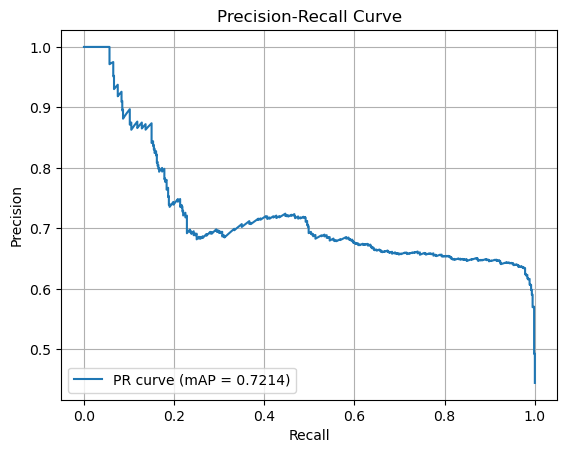

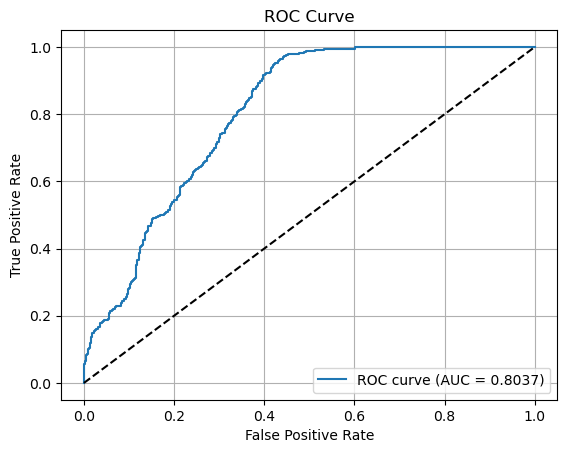

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]


In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.metrics import (
    roc_curve, roc_auc_score, confusion_matrix,
    average_precision_score, precision_recall_curve
)

def evaluate_signature_verificationtest(
    dtw_results, ground_truth,
    method='mean_k_smallest', k=3, alpha=0.5, use_exp=True
):
    """
    Évaluation finale des signatures avec plusieurs méthodes de calcul du score final.
    
    Parameters:
    - dtw_results: dict {sig_file: list of distances ou float}
    - ground_truth: dict {writer_id: {sig_id: label}}
    - method: str, méthode pour calculer le score final
        'mean_k_smallest', 'min_distance', 'median_distance', 'combined'
    - k: int, nombre de distances à utiliser pour mean_k_smallest ou combined
    - alpha: float, poids du min dans 'combined'
    - use_exp: bool, appliquer exp(-distance) pour améliorer séparation
    """
    
    y_true = []
    y_scores = []

    for sig_file, dist in dtw_results.items():
        sig_id = sig_file.replace('.tsv','')
        writer_id = sig_id.split('-')[0]

        if writer_id in ground_truth and sig_id in ground_truth[writer_id]:
            label = ground_truth[writer_id][sig_id]
            y_true.append(label)

            dist_list = dist if isinstance(dist, (list, np.ndarray)) else [dist]
            dist_sorted = sorted(dist_list)

            # Calcul du score final selon la méthode choisie
            if method == 'mean_k_smallest':
                score_val = np.mean(dist_sorted[:k])
            elif method == 'min_distance':
                score_val = min(dist_sorted)
            elif method == 'median_distance':
                score_val = np.median(dist_sorted)
            elif method == 'combined':
                score_val = alpha * min(dist_sorted) + (1 - alpha) * np.mean(dist_sorted[:k])
            else:
                raise ValueError("Méthode inconnue. Choisir parmi 'mean_k_smallest', 'min_distance', 'median_distance', 'combined'.")

            # Transformation exponentielle optionnelle
            score = np.exp(-score_val) if use_exp else -score_val
            y_scores.append(score)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # --- mean Average Precision (mAP) ---
    map_score = average_precision_score(y_true, y_scores)
    print(f"mAP: {map_score:.4f}")

    # --- Precision-Recall curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (mAP = {map_score:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    # --- ROC / AUC ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    print(f"AUC: {auc:.4f}")

    # --- EER ---
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    print(f"EER: {eer:.4f} at threshold {eer_threshold:.4f}")

    # --- Confusion matrix ---
    y_pred = (y_scores >= eer_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix at EER threshold:")
    print(cm)


# --- Exemple d'utilisation ---
# Charger DTW results
with open("dtw_results.pkl", "rb") as f:
    dtw_results = pickle.load(f)

# Charger ground truth
gt_df = pd.read_csv('gt.tsv', sep='\t', header=None, names=['sig_id','label'])
ground_truth = {}
for _, row in gt_df.iterrows():
    sig_id = row['sig_id']
    writer_id = sig_id.split('-')[0]
    label = 1 if row['label'].strip().lower() == 'genuine' else 0
    if writer_id not in ground_truth:
        ground_truth[writer_id] = {}
    ground_truth[writer_id][sig_id] = label

# --- Évaluation finale ---
#Méthode inconnue. Choisir parmi 'mean_k_smallest', 'min_distance', 'median_distance', 'combined'."
evaluate_signature_verificationtest(
    dtw_results, ground_truth,
    method='min_distance', k=4, alpha=0.7, use_exp=False
)



--- Test: method=mean_k_smallest, k=2, use_exp=True ---
mAP: 0.7214


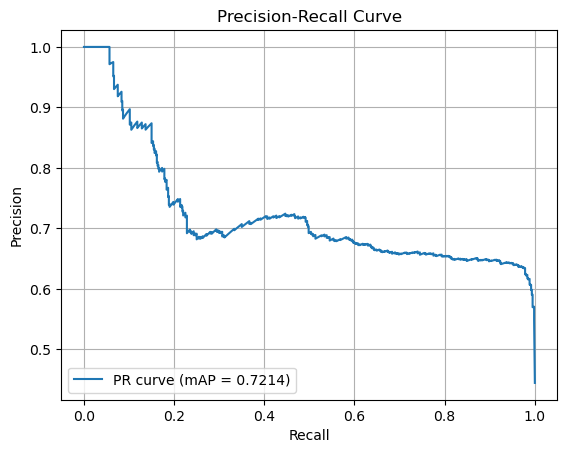

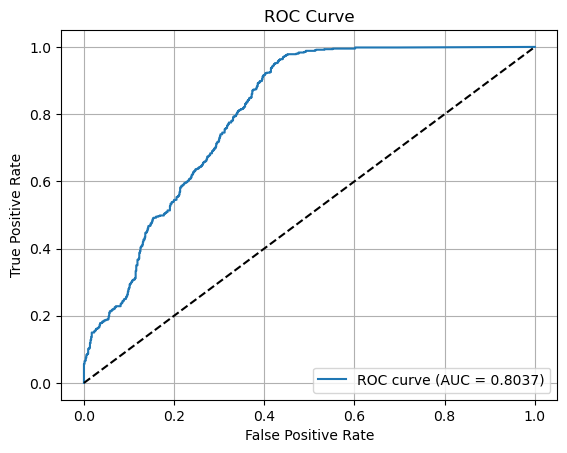

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=mean_k_smallest, k=2, use_exp=False ---
mAP: 0.7214


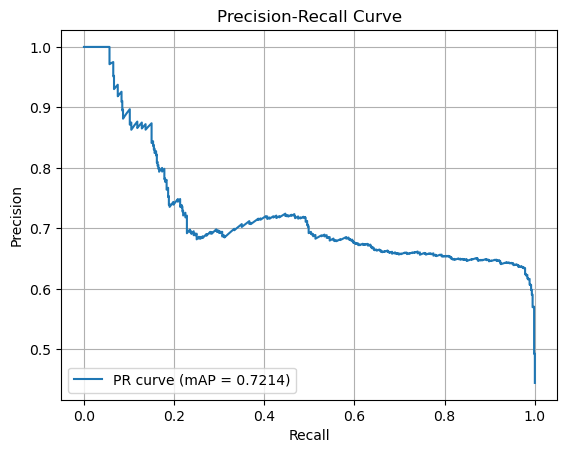

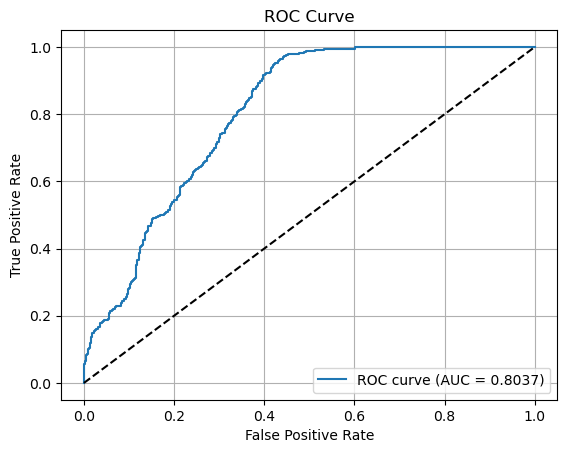

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=mean_k_smallest, k=3, use_exp=True ---
mAP: 0.7214


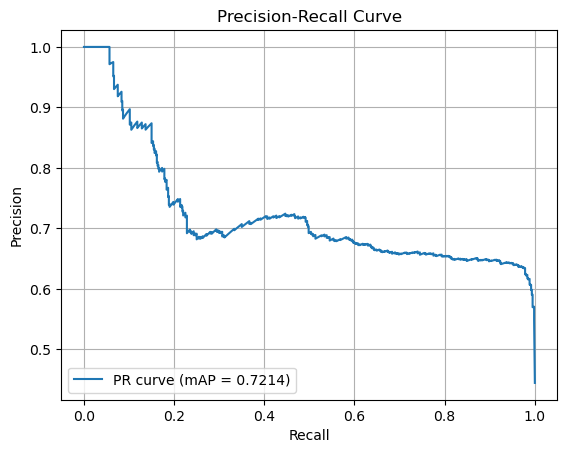

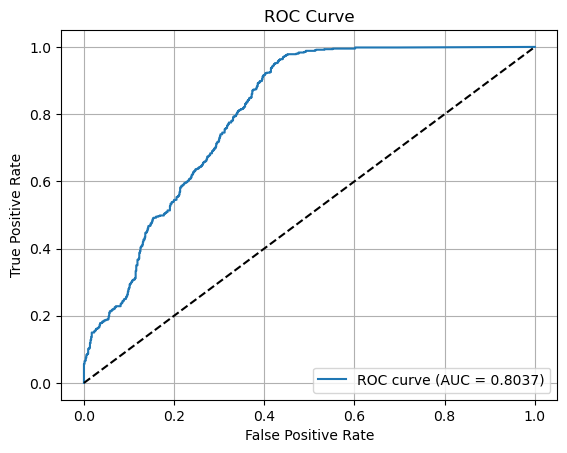

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=mean_k_smallest, k=3, use_exp=False ---
mAP: 0.7214


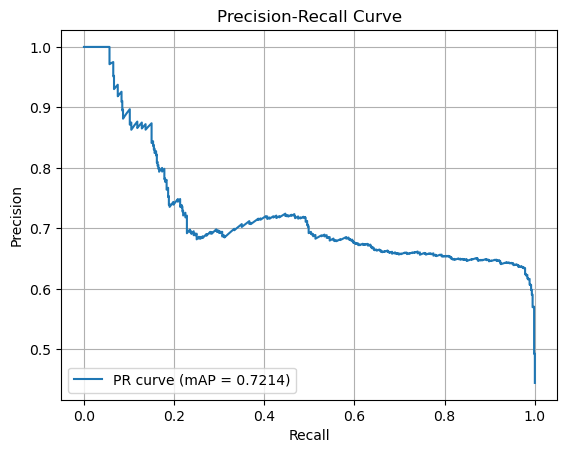

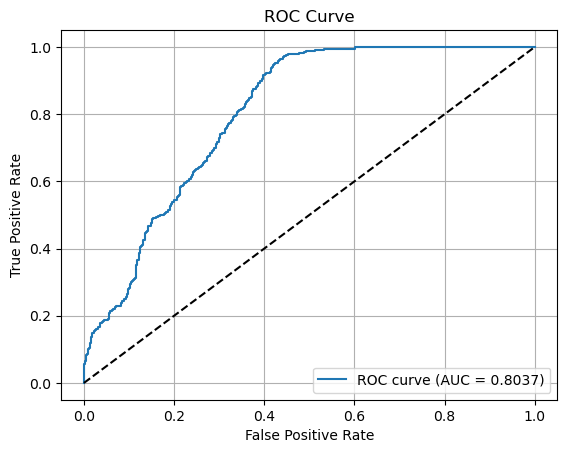

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=mean_k_smallest, k=4, use_exp=True ---
mAP: 0.7214


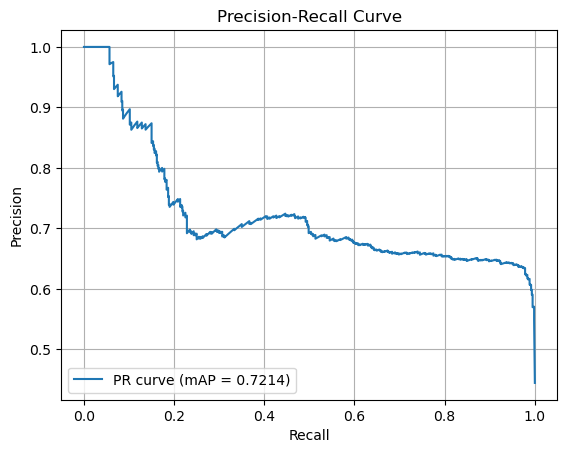

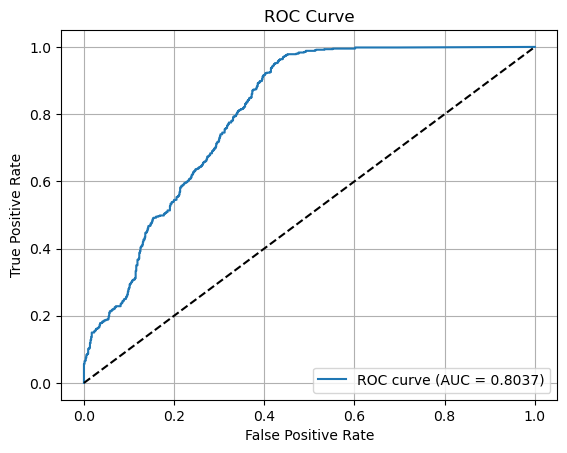

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=mean_k_smallest, k=4, use_exp=False ---
mAP: 0.7214


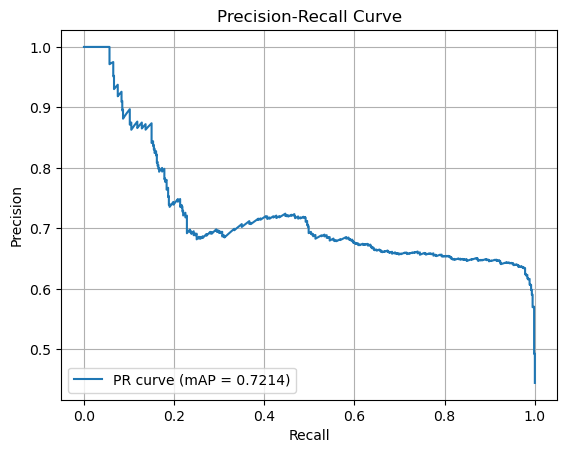

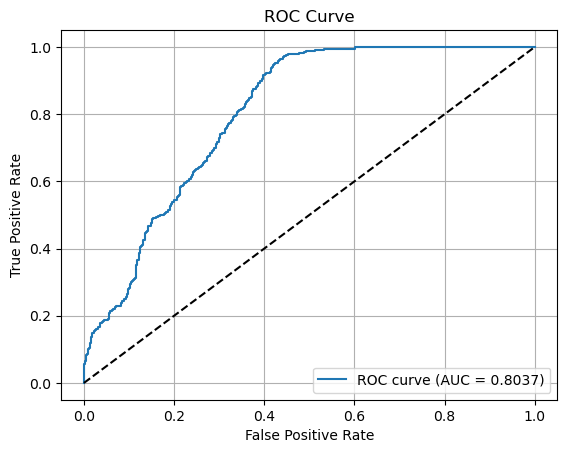

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=mean_k_smallest, k=5, use_exp=True ---
mAP: 0.7214


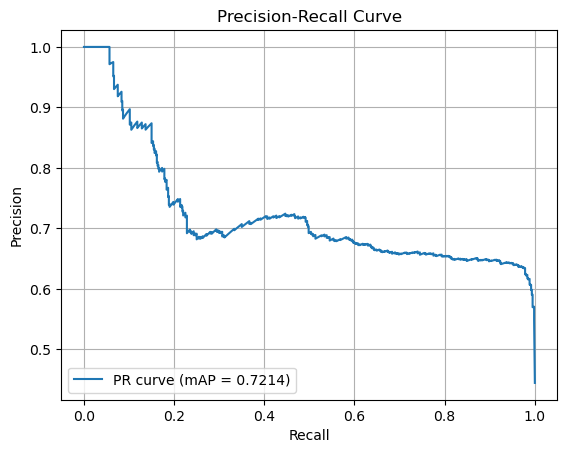

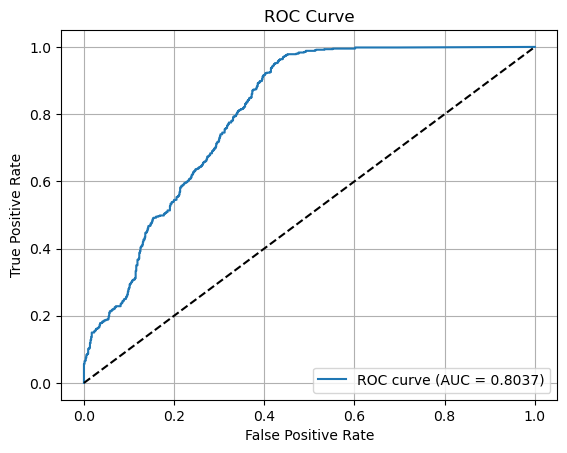

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=mean_k_smallest, k=5, use_exp=False ---
mAP: 0.7214


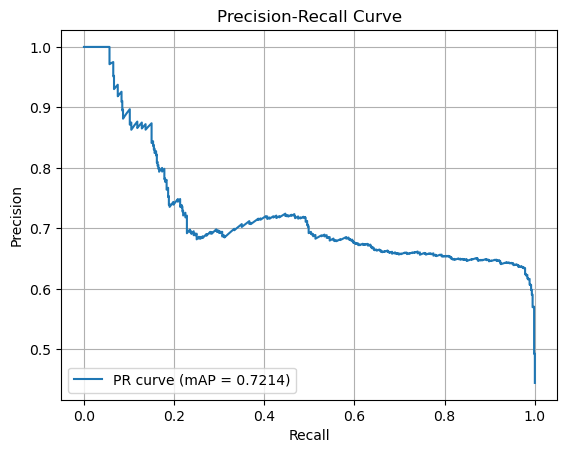

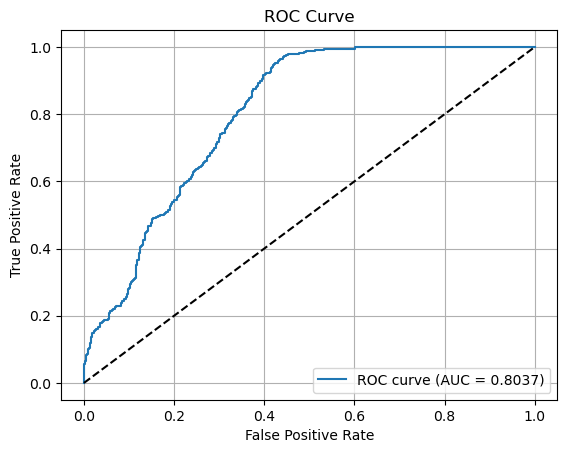

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=min_distance, k=2, use_exp=True ---
mAP: 0.7214


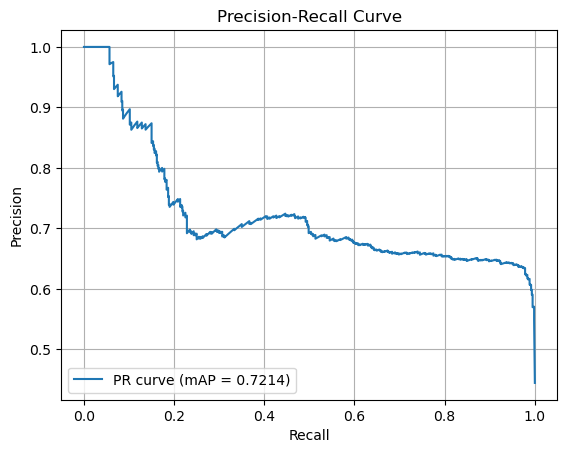

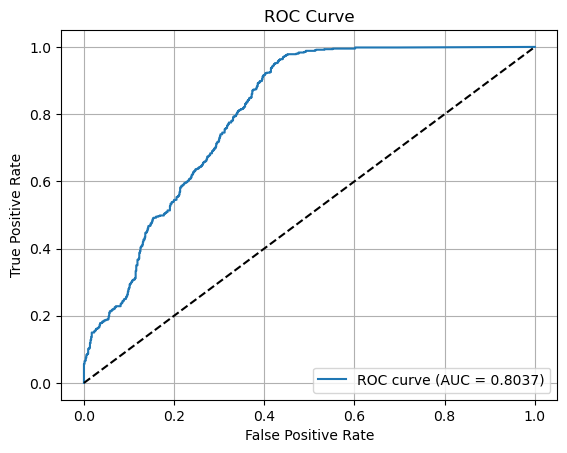

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=min_distance, k=2, use_exp=False ---
mAP: 0.7214


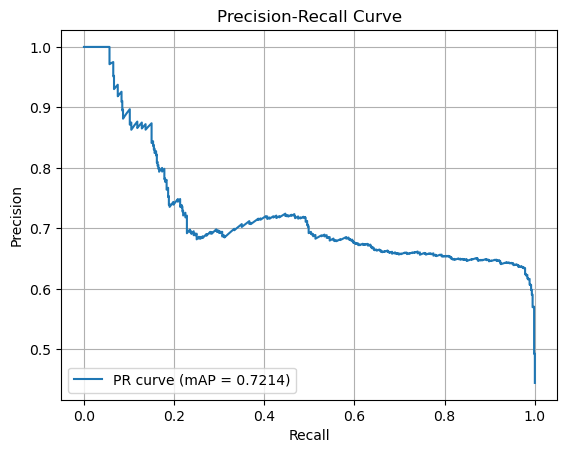

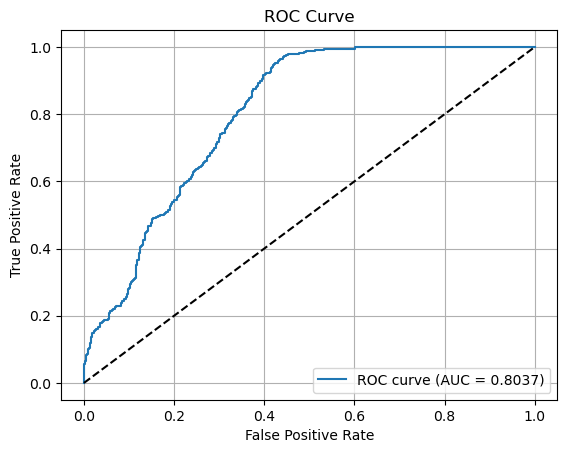

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=min_distance, k=3, use_exp=True ---
mAP: 0.7214


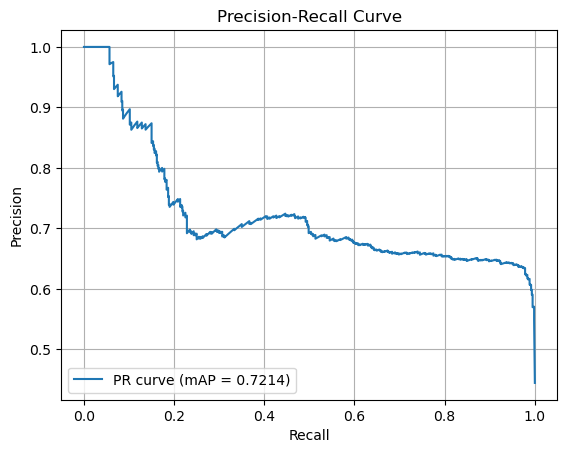

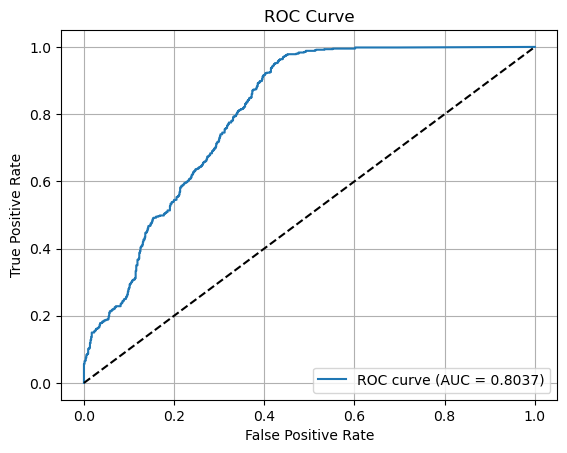

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=min_distance, k=3, use_exp=False ---
mAP: 0.7214


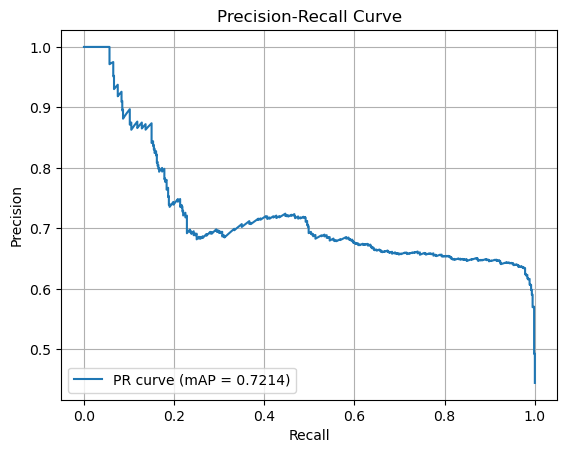

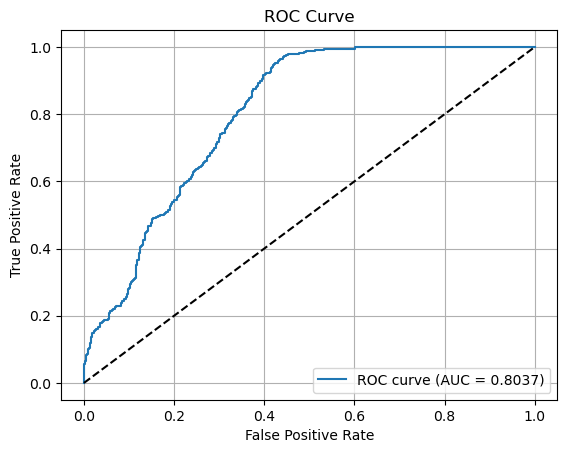

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=min_distance, k=4, use_exp=True ---
mAP: 0.7214


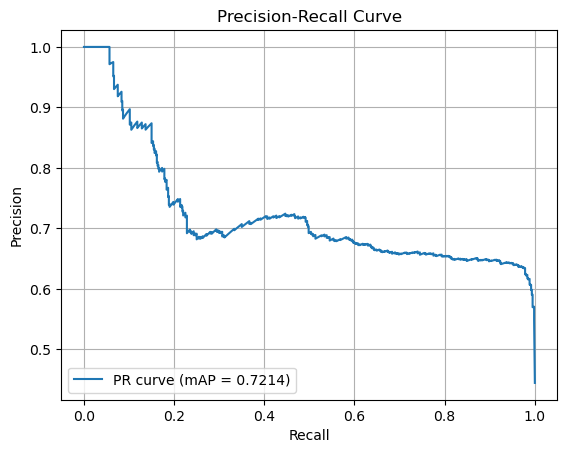

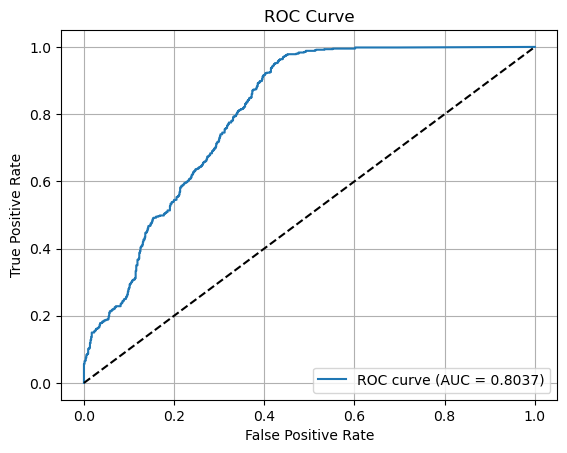

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=min_distance, k=4, use_exp=False ---
mAP: 0.7214


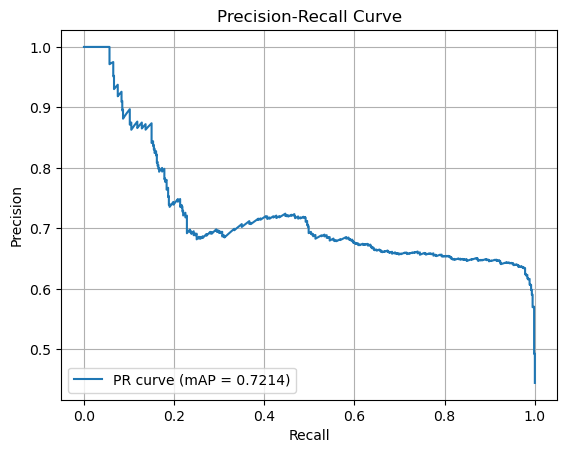

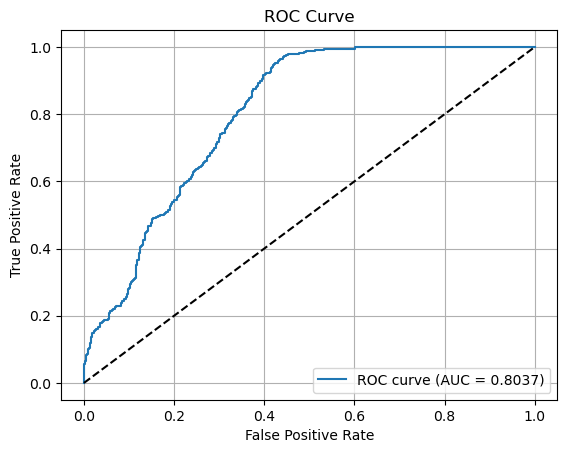

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=min_distance, k=5, use_exp=True ---
mAP: 0.7214


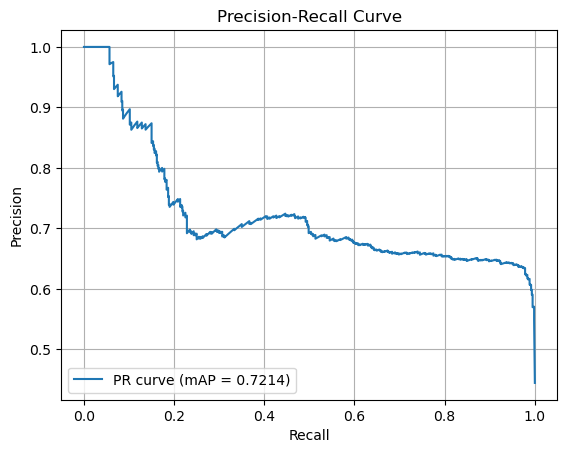

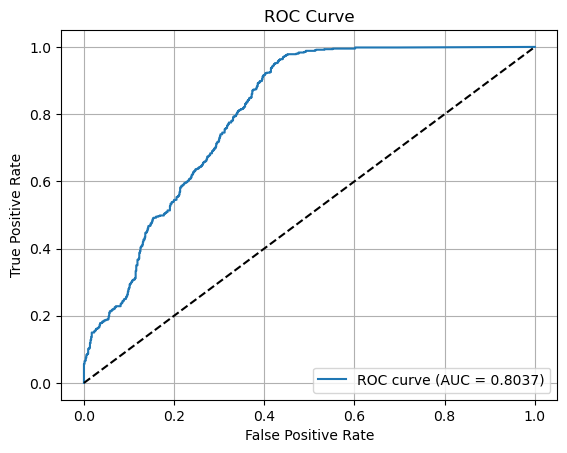

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=min_distance, k=5, use_exp=False ---
mAP: 0.7214


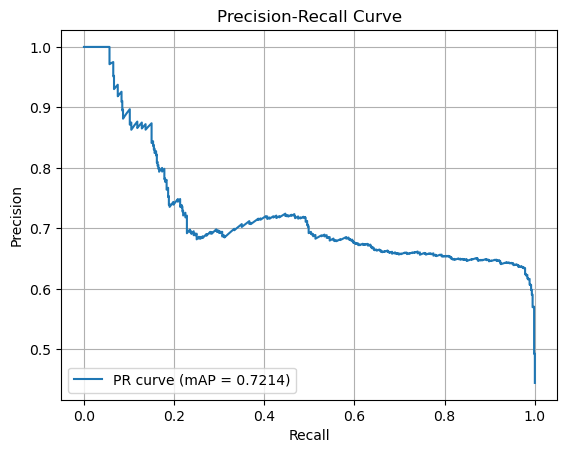

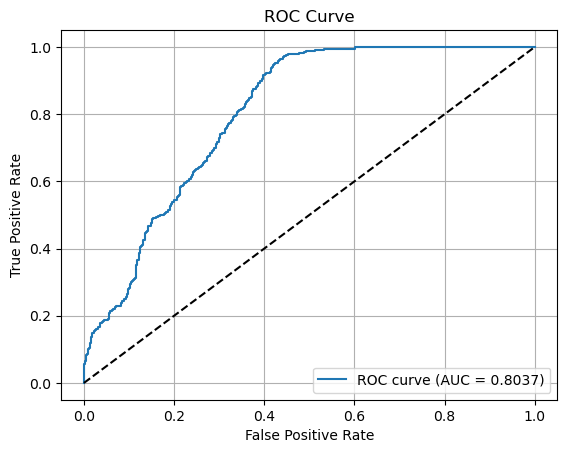

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=median_distance, k=2, use_exp=True ---
mAP: 0.7214


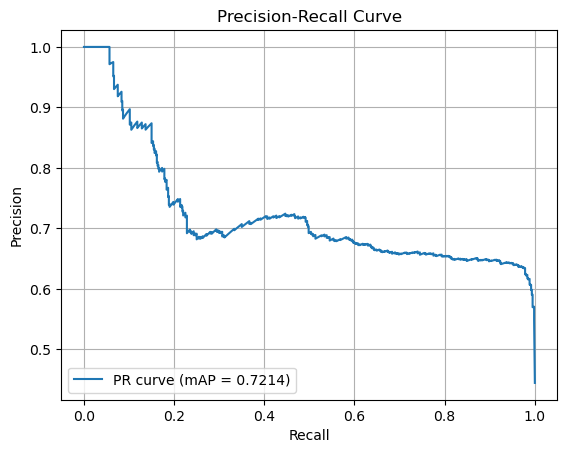

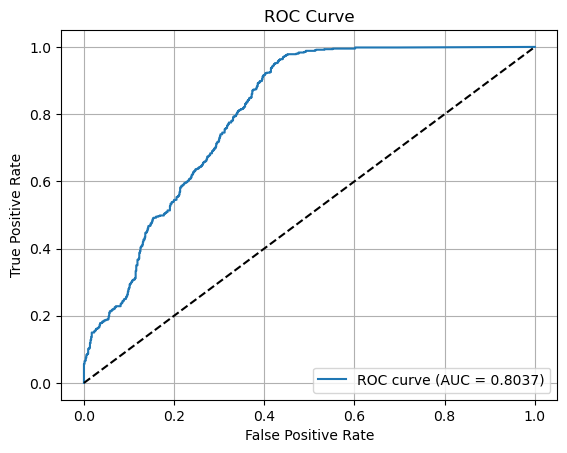

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=median_distance, k=2, use_exp=False ---
mAP: 0.7214


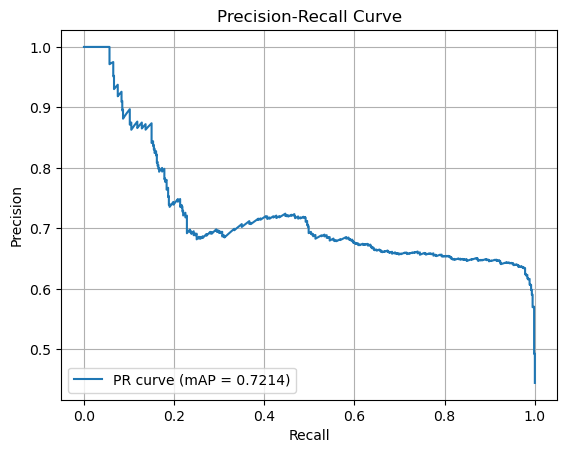

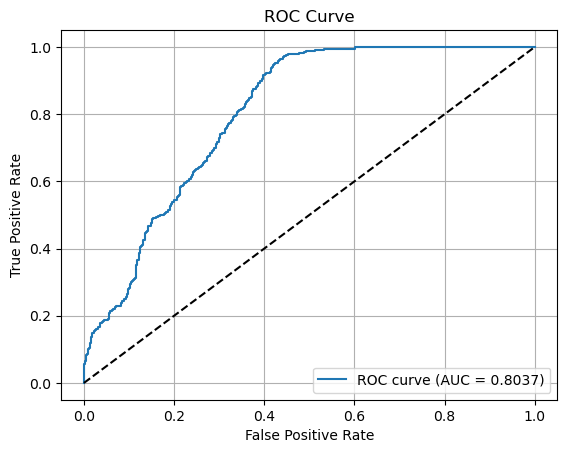

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=median_distance, k=3, use_exp=True ---
mAP: 0.7214


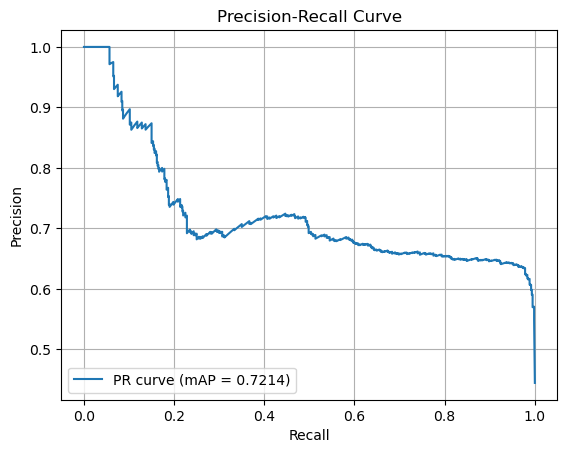

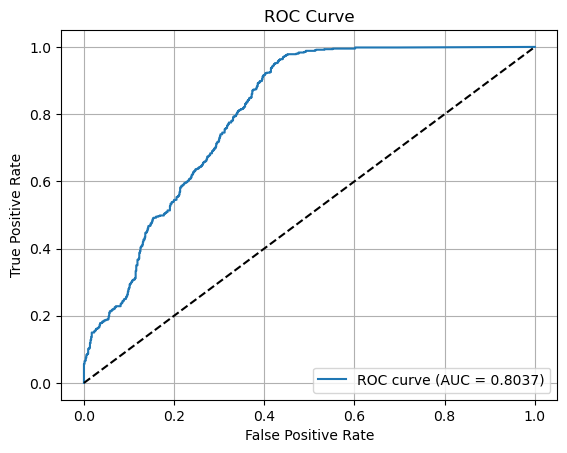

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=median_distance, k=3, use_exp=False ---
mAP: 0.7214


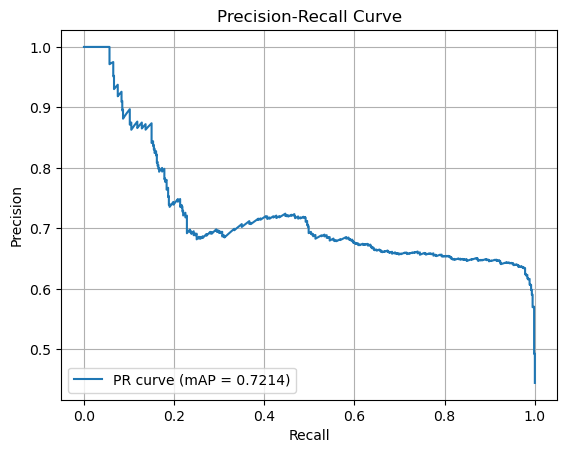

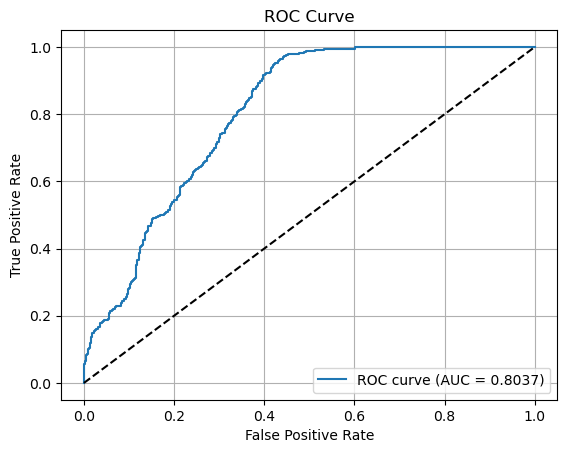

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=median_distance, k=4, use_exp=True ---
mAP: 0.7214


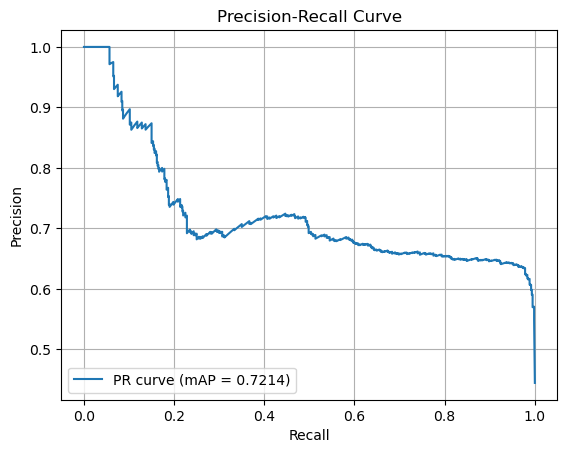

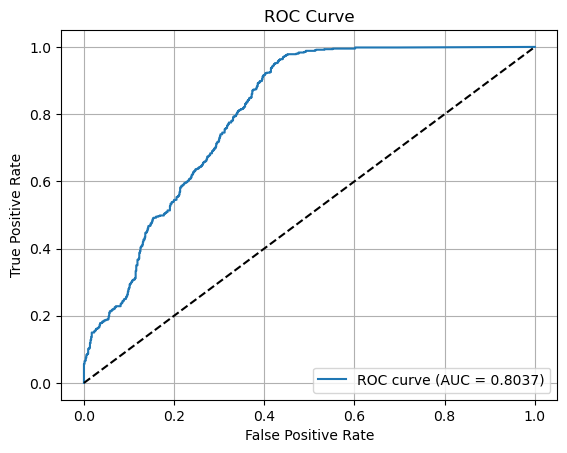

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=median_distance, k=4, use_exp=False ---
mAP: 0.7214


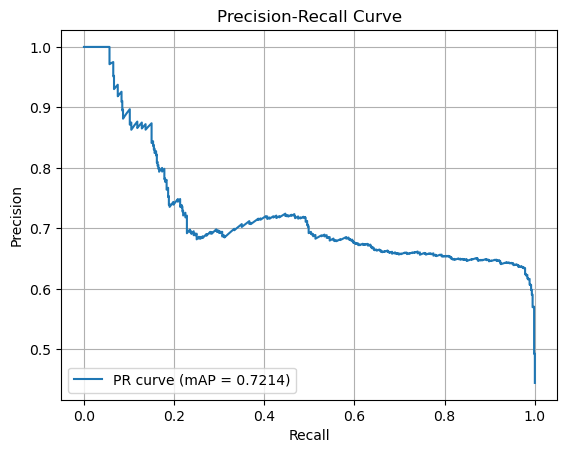

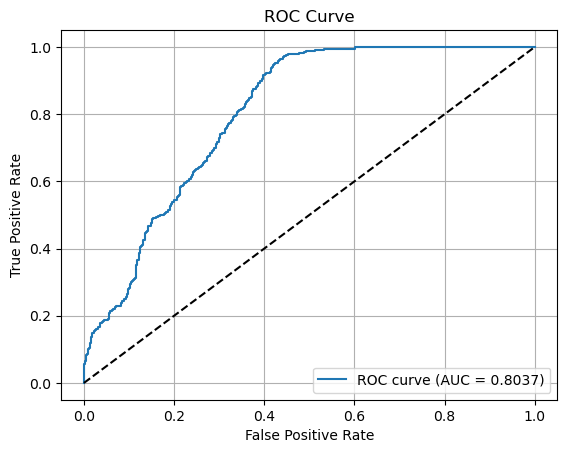

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=median_distance, k=5, use_exp=True ---
mAP: 0.7214


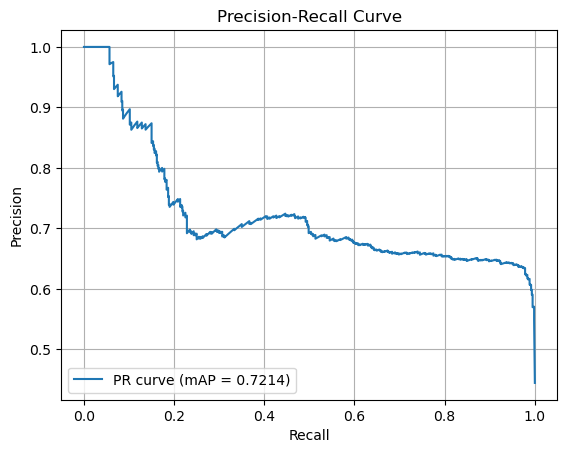

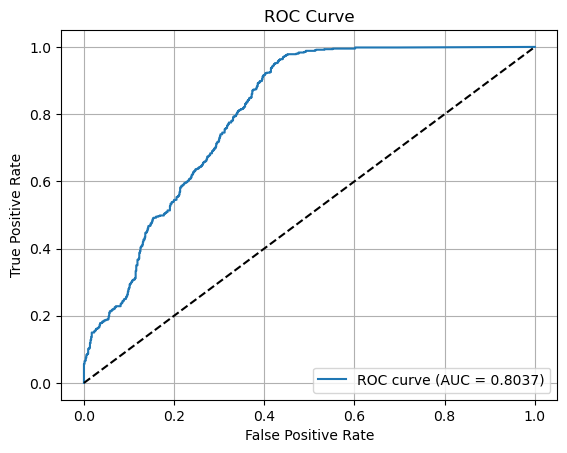

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=median_distance, k=5, use_exp=False ---
mAP: 0.7214


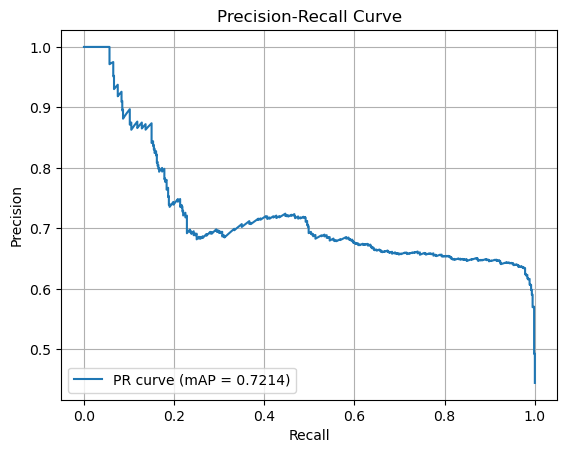

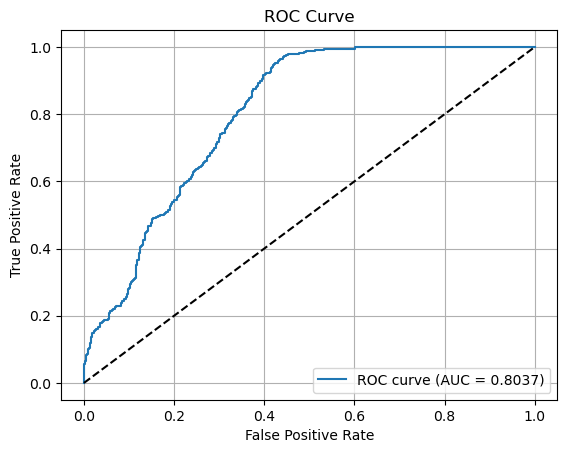

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=2, alpha=0.3, use_exp=True ---
mAP: 0.7214


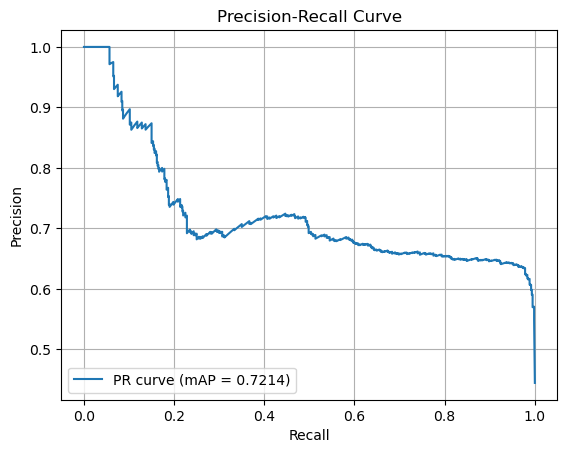

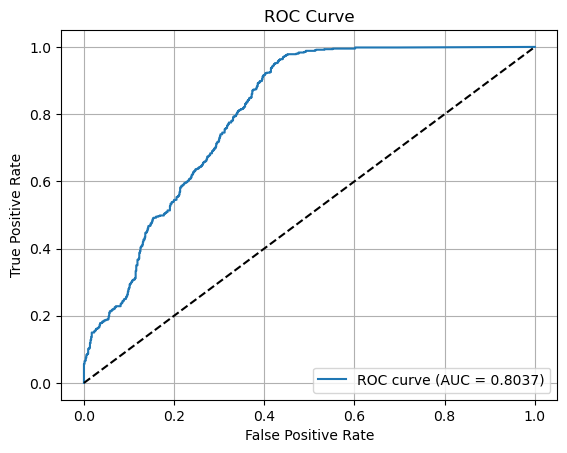

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=2, alpha=0.5, use_exp=True ---
mAP: 0.7214


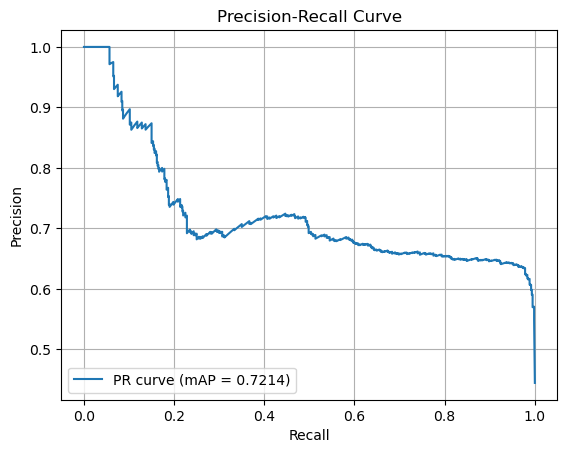

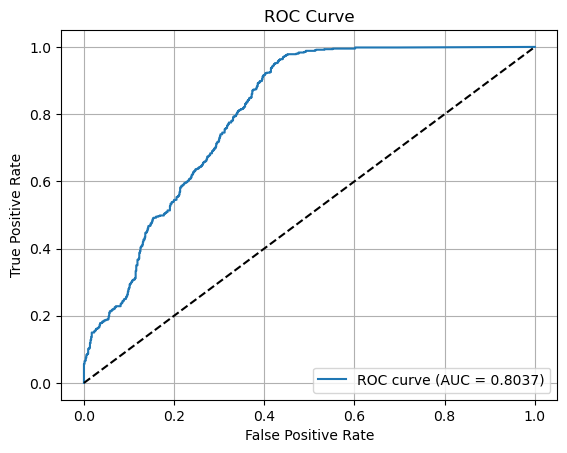

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=2, alpha=0.7, use_exp=True ---
mAP: 0.7214


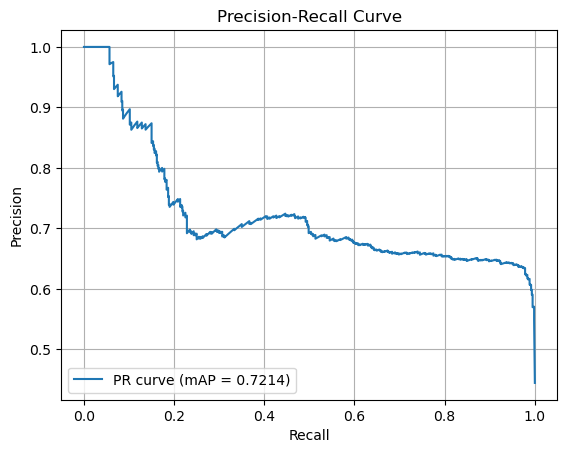

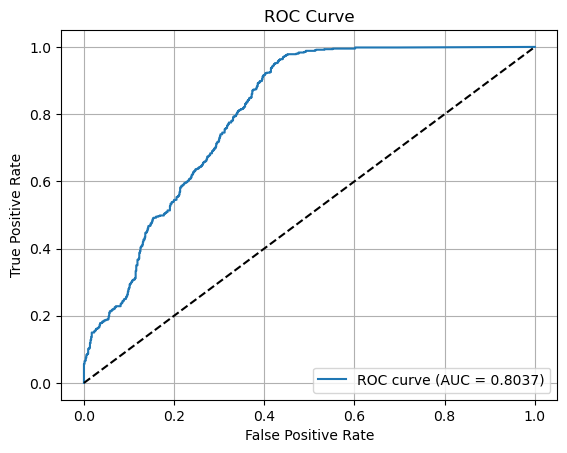

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=2, alpha=0.3, use_exp=False ---
mAP: 0.7214


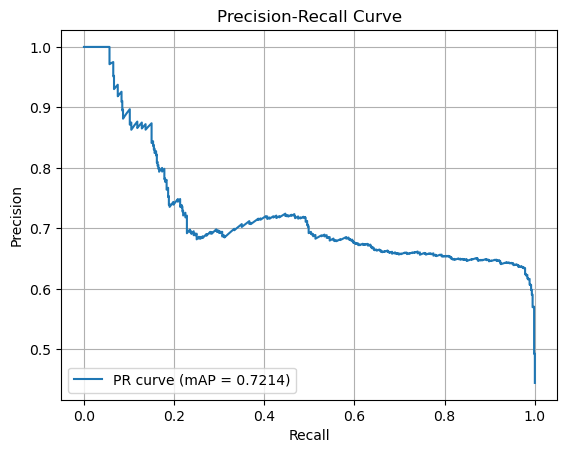

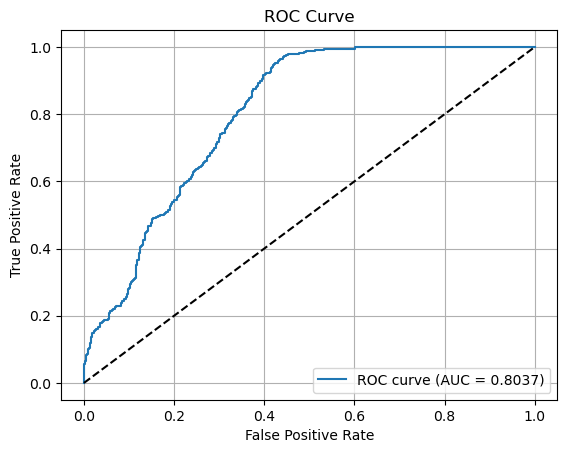

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=2, alpha=0.5, use_exp=False ---
mAP: 0.7214


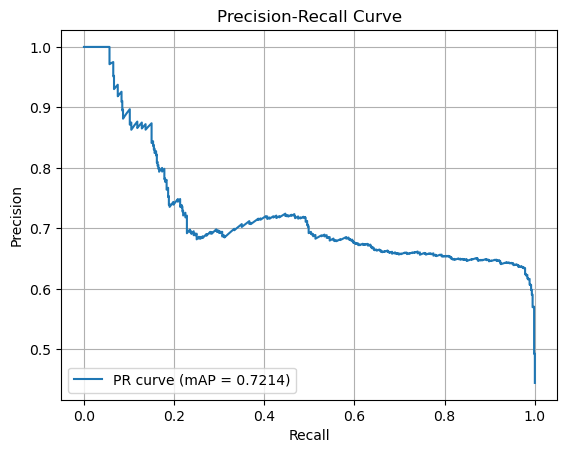

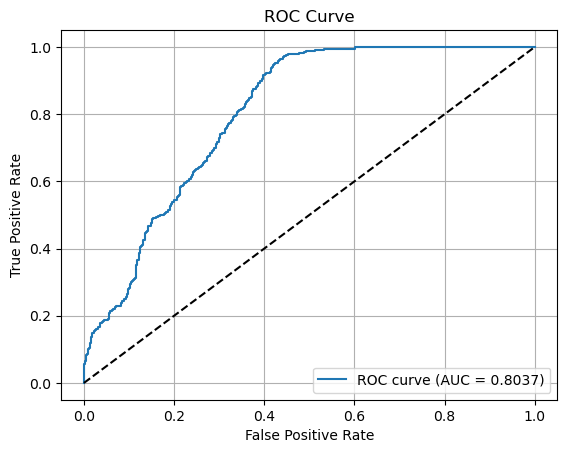

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=2, alpha=0.7, use_exp=False ---
mAP: 0.7214


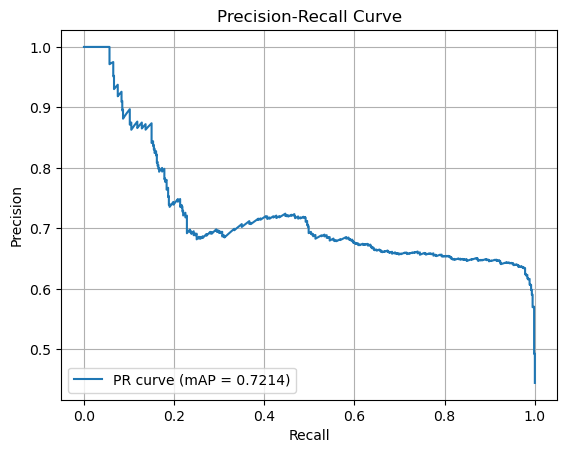

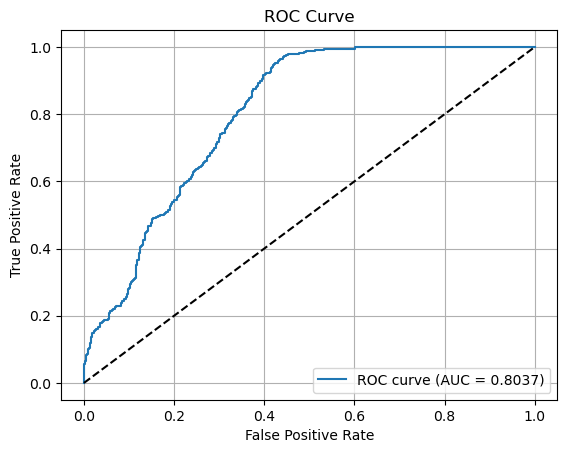

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=3, alpha=0.3, use_exp=True ---
mAP: 0.7214


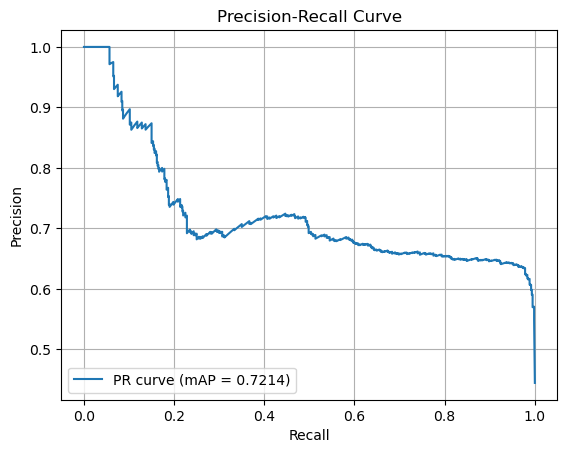

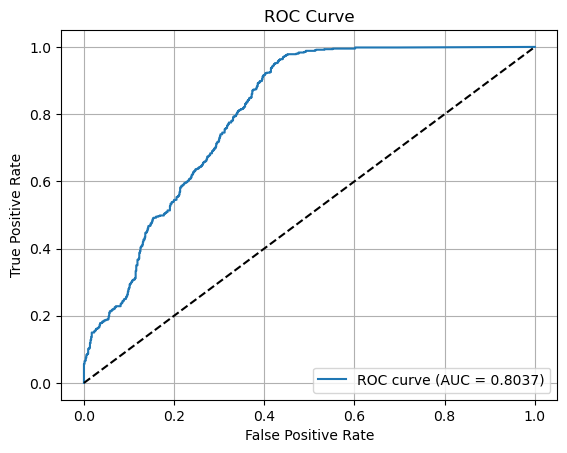

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=3, alpha=0.5, use_exp=True ---
mAP: 0.7214


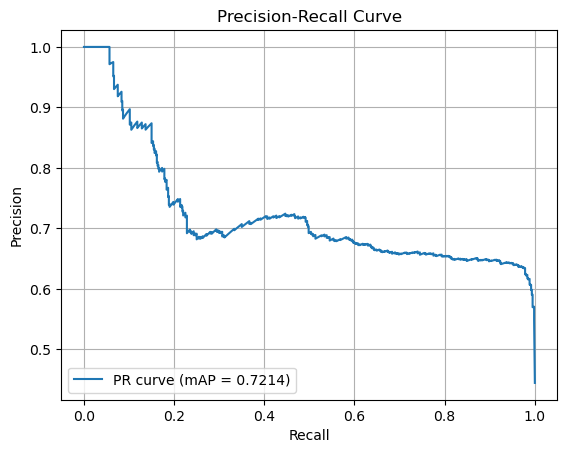

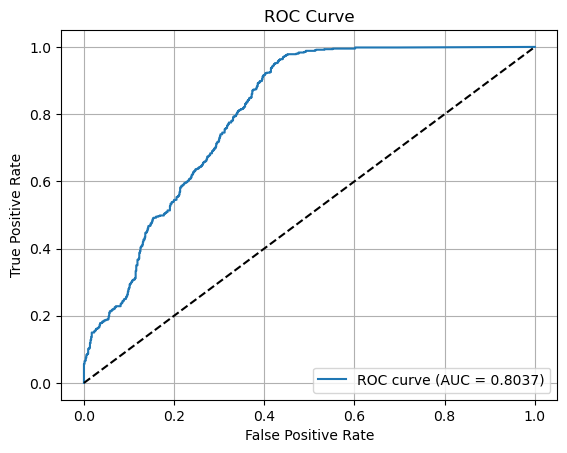

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=3, alpha=0.7, use_exp=True ---
mAP: 0.7214


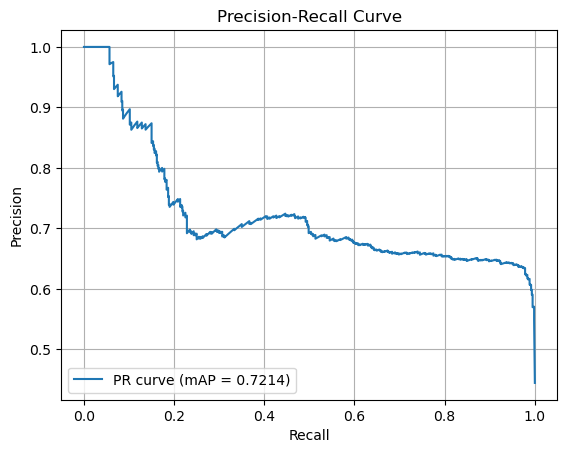

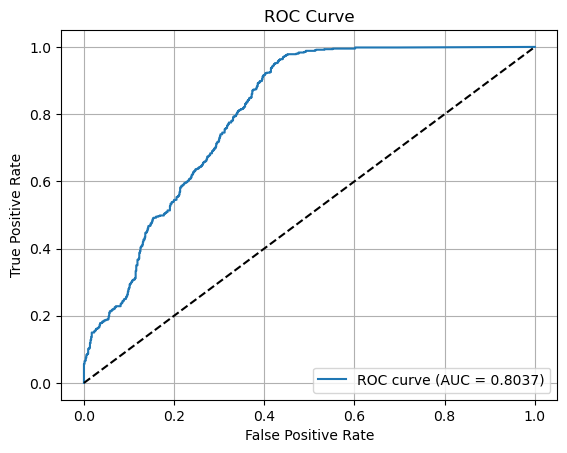

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=3, alpha=0.3, use_exp=False ---
mAP: 0.7214


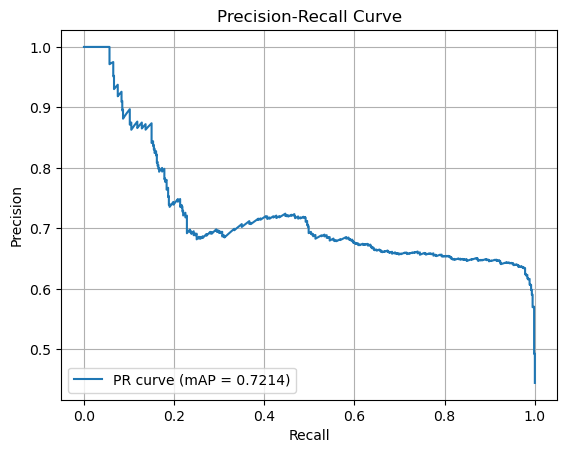

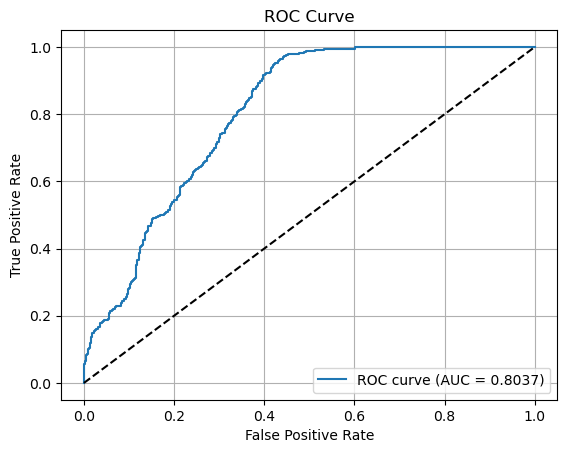

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=3, alpha=0.5, use_exp=False ---
mAP: 0.7214


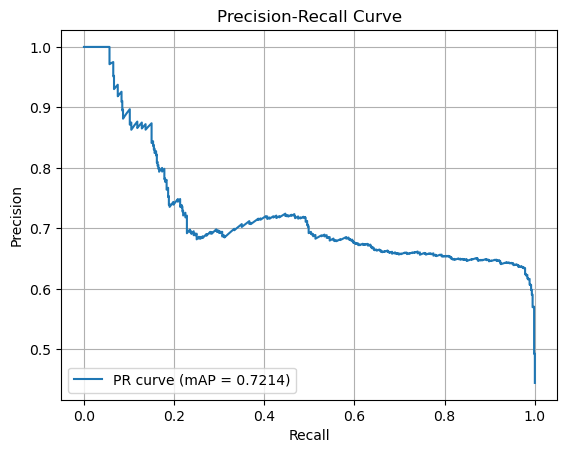

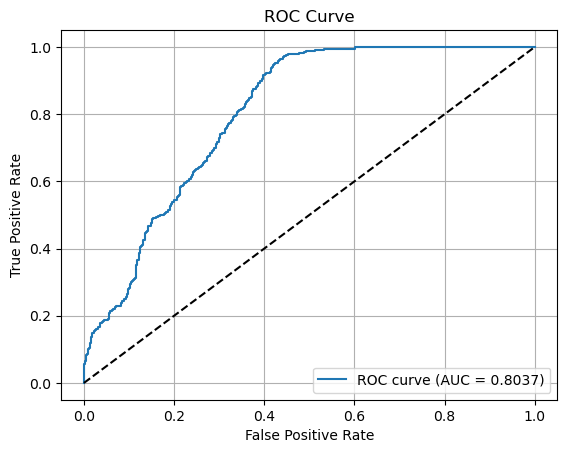

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=3, alpha=0.7, use_exp=False ---
mAP: 0.7214


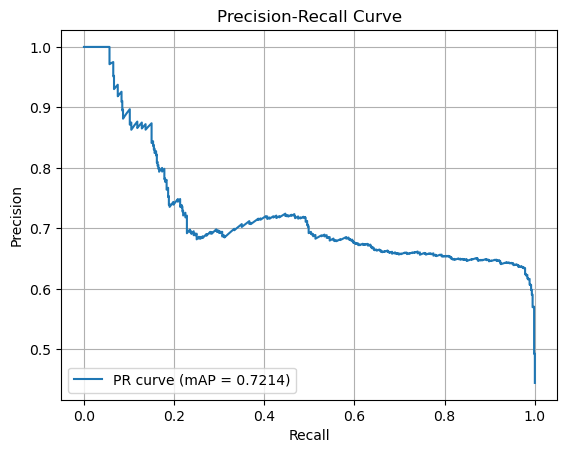

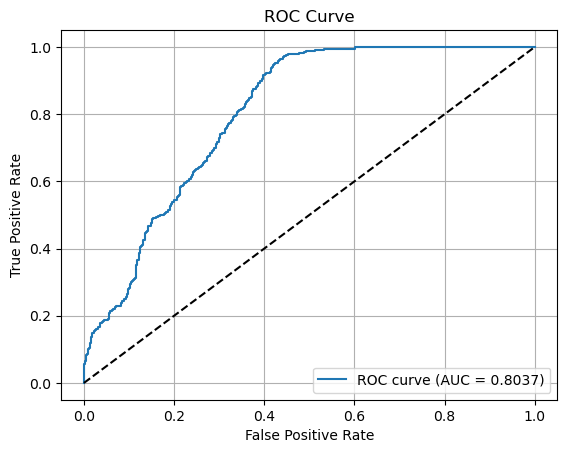

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=4, alpha=0.3, use_exp=True ---
mAP: 0.7214


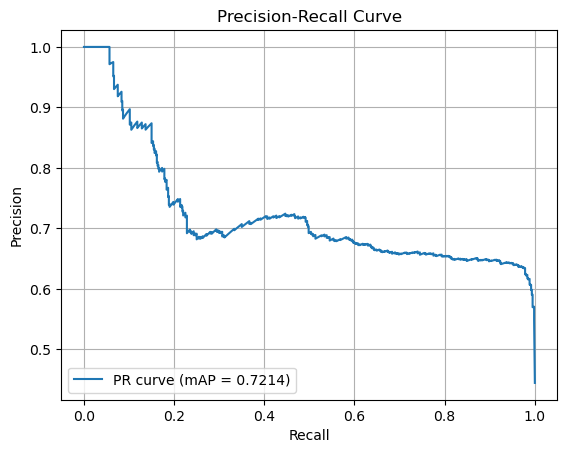

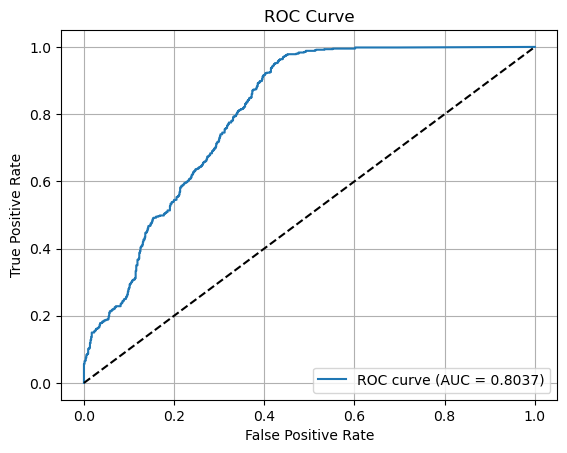

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=4, alpha=0.5, use_exp=True ---
mAP: 0.7214


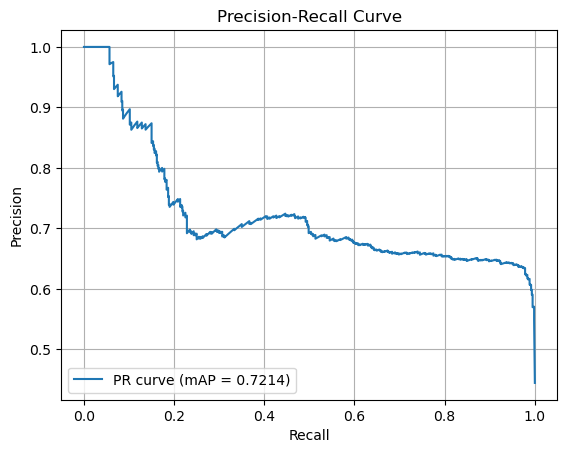

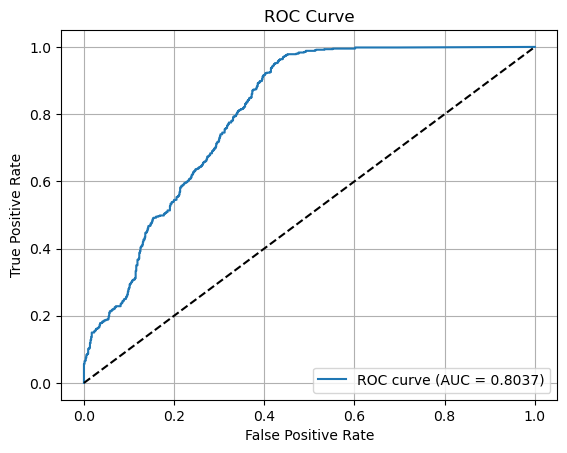

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=4, alpha=0.7, use_exp=True ---
mAP: 0.7214


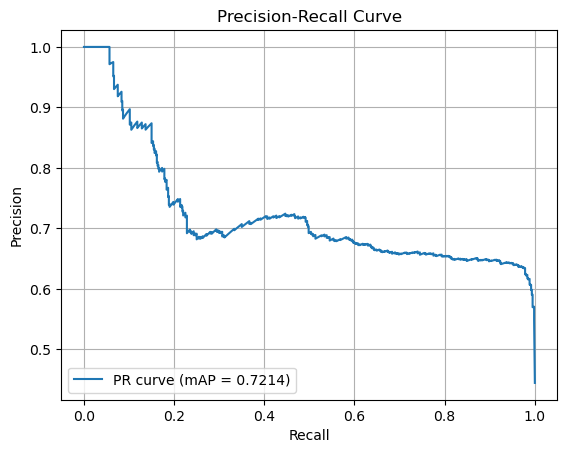

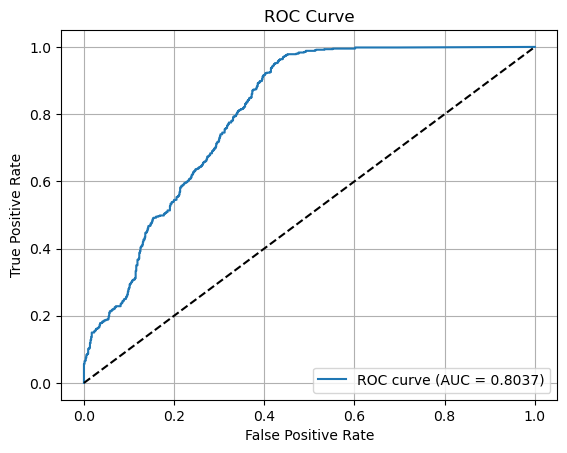

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=4, alpha=0.3, use_exp=False ---
mAP: 0.7214


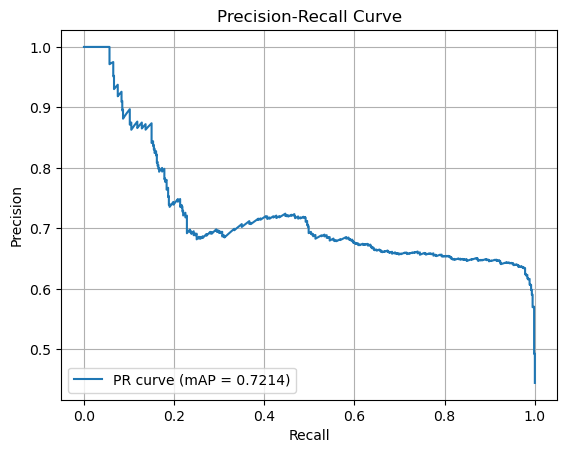

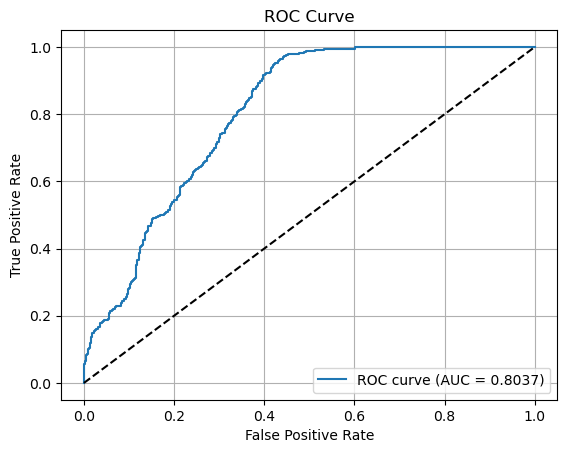

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=4, alpha=0.5, use_exp=False ---
mAP: 0.7214


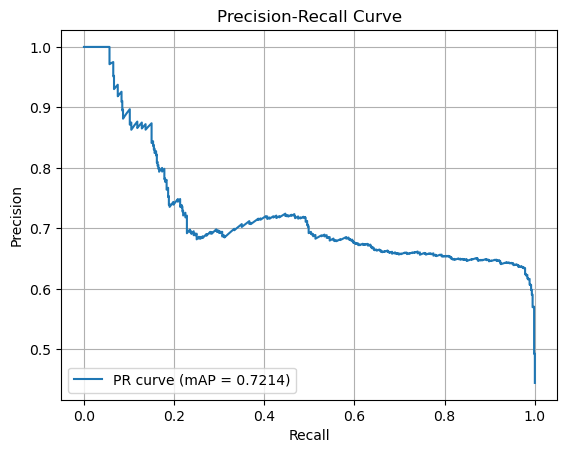

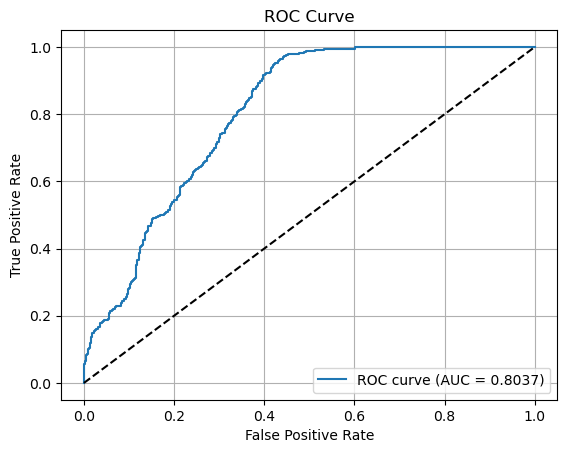

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=4, alpha=0.7, use_exp=False ---
mAP: 0.7214


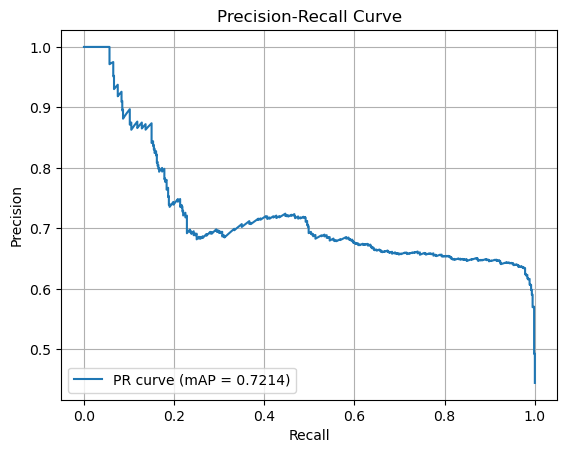

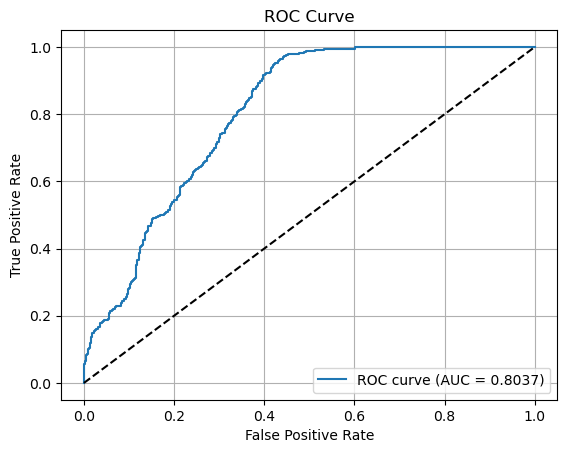

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=5, alpha=0.3, use_exp=True ---
mAP: 0.7214


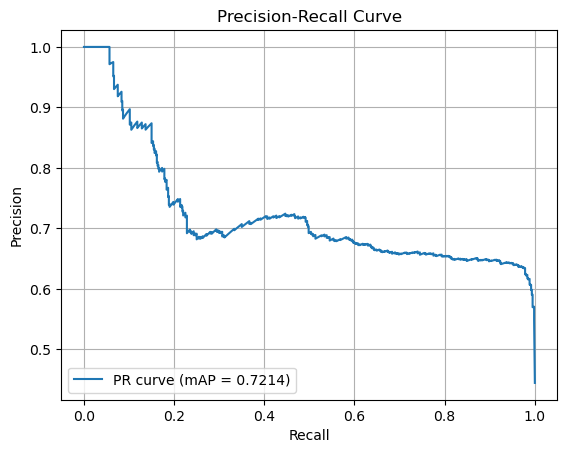

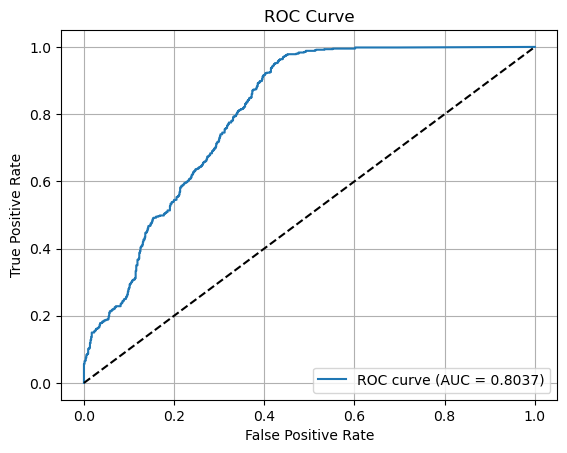

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=5, alpha=0.5, use_exp=True ---
mAP: 0.7214


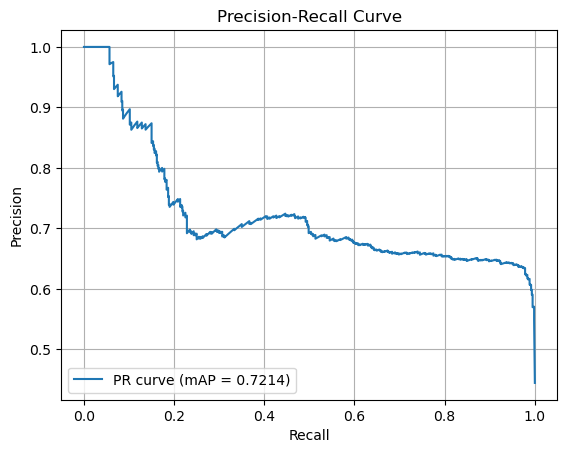

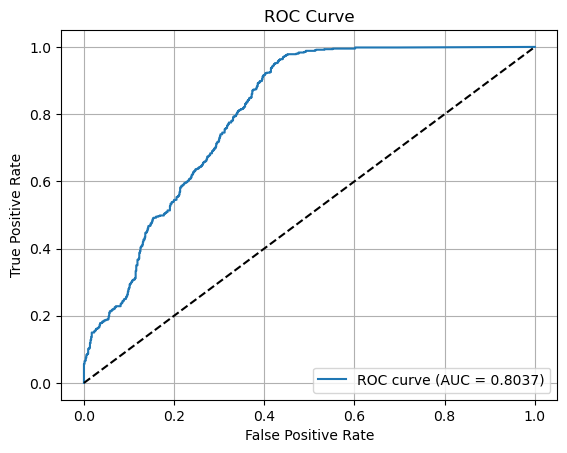

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=5, alpha=0.7, use_exp=True ---
mAP: 0.7214


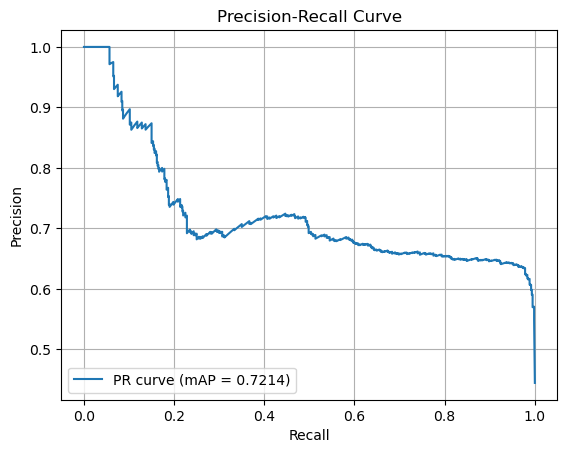

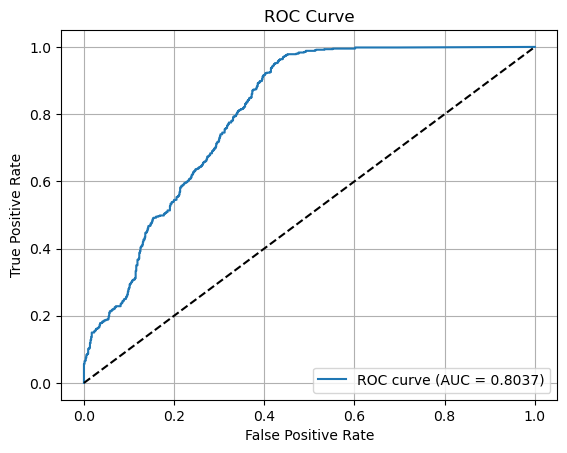

AUC: 0.8037
EER: 0.2933 at threshold 0.0000
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=5, alpha=0.3, use_exp=False ---
mAP: 0.7214


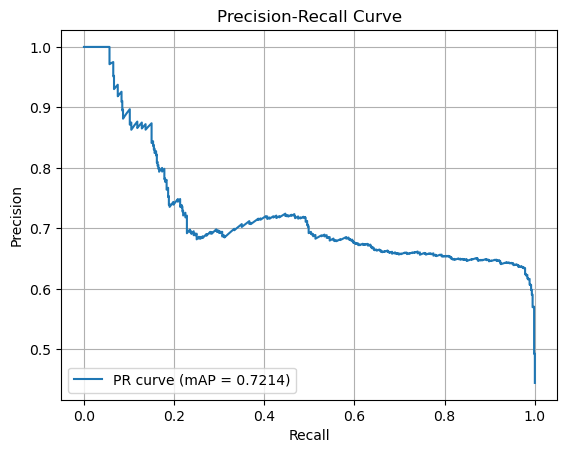

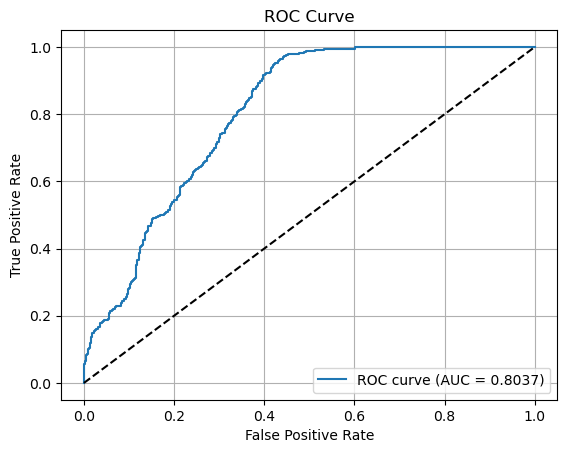

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=5, alpha=0.5, use_exp=False ---
mAP: 0.7214


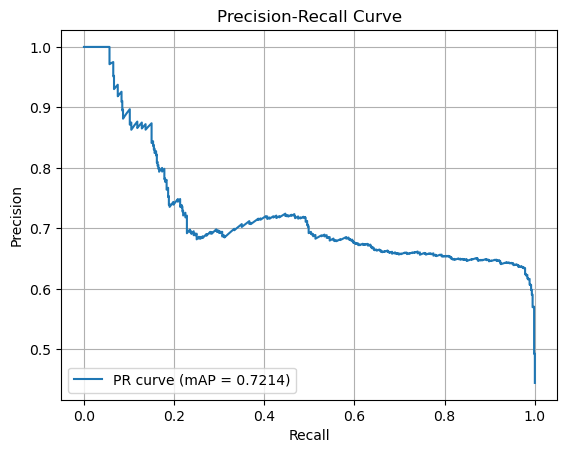

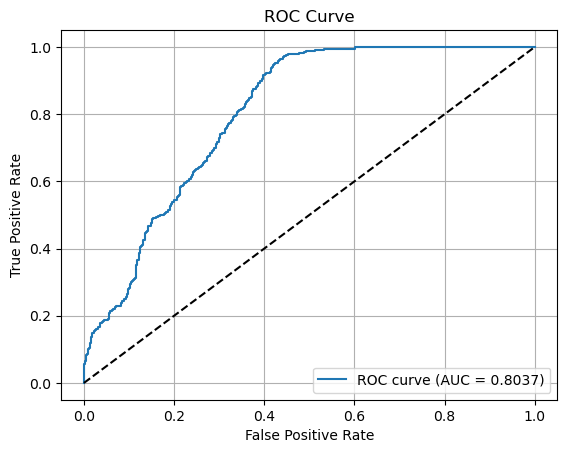

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]

--- Test: method=combined, k=5, alpha=0.7, use_exp=False ---
mAP: 0.7214


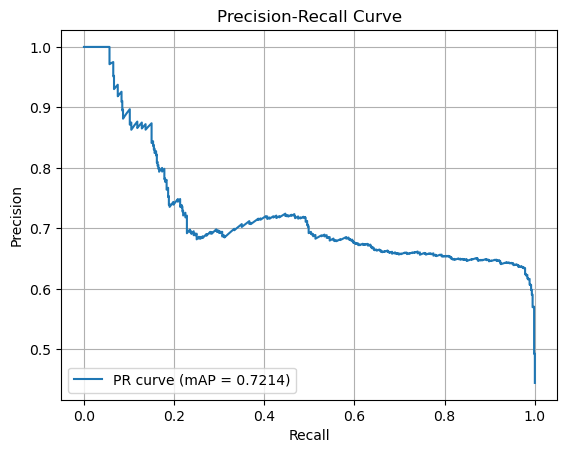

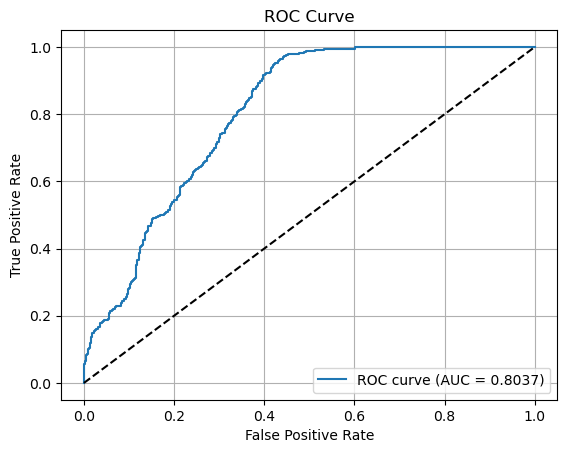

AUC: 0.8037
EER: 0.2933 at threshold -271.8601
Confusion Matrix at EER threshold:
[[530 220]
 [178 422]]


In [113]:
methods = ['mean_k_smallest', 'min_distance', 'median_distance', 'combined']
k_values = [2, 3, 4, 5]   # Nombre de distances à utiliser pour la moyenne ou combinaison
alpha_values = [0.3, 0.5, 0.7]  # Poids du min dans la méthode 'combined'
use_exp_options = [True, False]  # Avec ou sans transformation exponentielle

best_map = 0
best_config = None

for method in methods:
    for k in k_values:
        for use_exp in use_exp_options:
            if method == 'combined':
                for alpha in alpha_values:
                    print(f"\n--- Test: method={method}, k={k}, alpha={alpha}, use_exp={use_exp} ---")
                    evaluate_signature_verificationtest(
                        dtw_results, ground_truth,
                        method=method, k=k, alpha=alpha, use_exp=use_exp
                    )
            else:
                print(f"\n--- Test: method={method}, k={k}, use_exp={use_exp} ---")
                evaluate_signature_verificationtest(
                    dtw_results, ground_truth,
                    method=method, k=k, alpha=0.5, use_exp=use_exp
                )
